<a href="https://colab.research.google.com/github/sidhu820/pima-diabetics-pytorch/blob/main/Task_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
url='https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv'
df = pd.read_csv(url)
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
x=df.drop('Outcome',axis=1).values
y=df['Outcome'].values
sc = StandardScaler()
x= sc.fit_transform(x)

In [ ]:
X = torch.FloatTensor(x)
y = torch.FloatTensor(y).reshape(-1,1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2, random_state = 42, shuffle= True)
X_train,X_val,y_train,y_val = train_test_split( X_train, y_train, test_size= 0.2, random_state = 42, shuffle= True)

In [ ]:
class Pimaclassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(8,12)
        self.h1 = nn.Linear(12,10)
        self.output = nn.Linear(10,1)

    def forward(self, x):

        x = F.relu(self.input(x))
        x = F.relu(self.h1(x))
        x = F.sigmoid(self.output(x))

        return x

In [ ]:
torch.manual_seed(29)
first_model = Pimaclassifier()
first_model

Pimaclassifier(
  (input): Linear(in_features=8, out_features=12, bias=True)
  (h1): Linear(in_features=12, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_1 = nn.BCELoss()
optimizer = optim.Adam(first_model.parameters(), lr = 0.0001)

In [ ]:
epochs = 130
batch_size = 20
training_loss = []
validation_loss = []


for epoch in range(epochs):
    epoch_loss = 0
    taccuracy = 0
    first_model.train()
    optimizer.zero_grad()
    for i in range(0, len(X_train), batch_size):
        Xbatch = X_train[i:i+batch_size]
        ybatch = y_train[i:i+batch_size]
        y_pred = first_model(Xbatch)
        loss = loss_1(y_pred,ybatch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        taccuracy += (y_pred.round() == ybatch).float().mean()

    epoch_loss /= len(X_train) / batch_size
    training_loss.append(epoch_loss)

    with torch.no_grad():
        first_model.eval()
        val_pred = first_model(X_val)
        loss = loss_1(val_pred,y_val)
        validation_loss.append(loss.item())
        accuracy = (val_pred.round() == y_val).float().mean()
    if (epoch+1) % 10 == 0:
        print(f'epoch :{epoch},training loss : {epoch_loss}, validation loss :{loss.item()},\ntraining accuracy :{taccuracy/(len(X_train) / batch_size)}, validation accuracy :{accuracy}')


epoch :9,training loss : 0.7553547851422654, validation loss :0.7456566691398621,
training accuracy :0.3532679080963135, validation accuracy :0.3414634168148041
epoch :19,training loss : 0.7155097404953904, validation loss :0.7063246965408325,
training accuracy :0.4367709755897522, validation accuracy :0.4390243887901306
epoch :29,training loss : 0.6684897557781088, validation loss :0.6627535223960876,
training accuracy :0.6711720824241638, validation accuracy :0.6178861856460571
epoch :39,training loss : 0.6215777076674576, validation loss :0.6218525171279907,
training accuracy :0.6976485848426819, validation accuracy :0.6910569071769714
epoch :49,training loss : 0.5849033205669426, validation loss :0.5929327607154846,
training accuracy :0.7220885157585144, validation accuracy :0.707317054271698
epoch :59,training loss : 0.558144174622421, validation loss :0.5721660852432251,
training accuracy :0.7183855175971985, validation accuracy :0.7154471278190613
epoch :69,training loss : 0.536

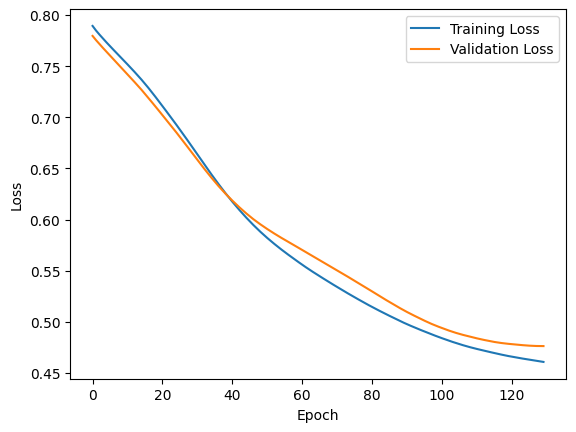

In [ ]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    first_model.eval()
    y_test_pred = first_model(X_test)
    loss_val = loss_1(y_test_pred, y_test).item()

    correct = (y_test_pred.round() == y_test).float().sum()
    total = float(y_test.size(0))
    print("Testing Accuracy :",((correct / total) * 100 ).item())
    print(f"got {correct} correct from {len(X_test)}")

Testing Accuracy : 74.0259780883789
got 114.0 correct from 154


In [ ]:
def add_noise(X_train,y_train,num_of_times,mean=0.1,std=0.2):

  new_X_train=[]
  new_y_train=[]

  for _ in range(num_of_times):
    # data=X_train.clone
    noisy_data=X_train[:,1:].clone()
    noise=torch.randn_like(noisy_data) * std + mean
    noisy_data += noise
    noisy_data = torch.cat((X_train[:,0].unsqueeze(1),noisy_data), dim=1)
    new_X_train.append(noisy_data)
    new_y_train.append(y_train.clone())

  return torch.cat(new_X_train, dim=0) , torch.cat(new_y_train, dim=0)


X_train_noisy,y_train_noisy = add_noise(X_train,y_train,num_of_times=2)

In [ ]:
torch.manual_seed(37)
# 37 150 100
new_model = Pimaclassifier()
new_model

Pimaclassifier(
  (input): Linear(in_features=8, out_features=12, bias=True)
  (h1): Linear(in_features=12, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
loss_2 = nn.BCELoss()
optimizer_new = optim.Adam(new_model.parameters(), lr = 0.0001)

In [ ]:
epochs = 150
batch_size = 100
# 140, 60, 150, 75, 150, 80, 90, 175, 95,
training_loss = []
validation_loss = []


for epoch in range(epochs):
    epoch_loss = 0
    taccuracy = 0
    new_model.train()
    optimizer_new.zero_grad()
    for i in range(0, len(X_train_noisy), batch_size):
        Xbatch = X_train_noisy[i:i+batch_size]
        ybatch = y_train_noisy[i:i+batch_size]
        noise_pred = new_model(Xbatch)
        loss = loss_2(noise_pred,ybatch)
        epoch_loss += loss.item()
        loss.backward()
        optimizer_new.step()
        taccuracy += (noise_pred.round() == ybatch).float().mean()

    epoch_loss /= len(X_train_noisy) / batch_size
    training_loss.append(epoch_loss)

    with torch.no_grad():
        new_model.eval()
        noise_val_pred = new_model(X_val)
        loss = loss_2(noise_val_pred,y_val)
        validation_loss.append(loss.item())
        accuracy = (noise_val_pred.round() == y_val).float().mean()

    if (epoch+1) % 10 == 0:
        print(f'epoch :{epoch},training loss : {epoch_loss}, validation loss :{loss.item()},\ntraining accuracy :{taccuracy/(len(X_train_noisy) / batch_size)}, validation accuracy :{accuracy}')

epoch :9,training loss : 0.6694817737260806, validation loss :0.6563990116119385,
training accuracy :0.6642491221427917, validation accuracy :0.6585366129875183
epoch :19,training loss : 0.6626137344511852, validation loss :0.6493957042694092,
training accuracy :0.6673041582107544, validation accuracy :0.6585366129875183
epoch :29,training loss : 0.6542768473537779, validation loss :0.6404389142990112,
training accuracy :0.6764692068099976, validation accuracy :0.6666666865348816
epoch :39,training loss : 0.6440636582384284, validation loss :0.6294048428535461,
training accuracy :0.6954697370529175, validation accuracy :0.6991869807243347
epoch :49,training loss : 0.6317398577260874, validation loss :0.616394579410553,
training accuracy :0.7075654864311218, validation accuracy :0.707317054271698
epoch :59,training loss : 0.6181794975537146, validation loss :0.6022053360939026,
training accuracy :0.7212508320808411, validation accuracy :0.7154471278190613
epoch :69,training loss : 0.603

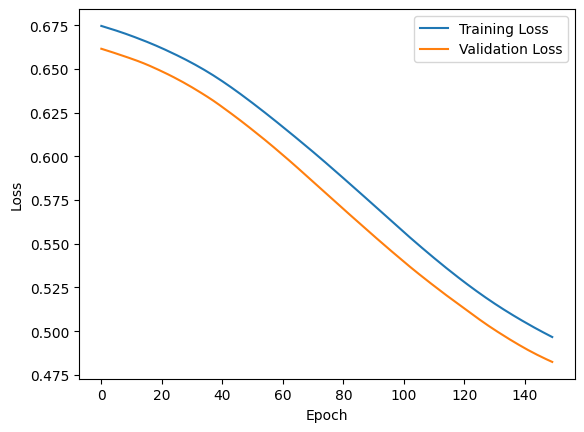

In [ ]:
plt.plot(training_loss, label = 'Training Loss')
plt.plot(validation_loss, label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    new_model.eval()
    noise_test = new_model(X_test)
    loss_val = loss_2(noise_test, y_test).item()

    correct = (noise_test.round() == y_test).float().sum()
    total = float(y_test.size(0))
    print("Testing Accuracy :",((correct / total) * 100 ).item())
    print(f"got {correct} correct from {len(X_test)}")

Testing Accuracy : 80.51947784423828
got 124.0 correct from 154
